In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler
from open_clip import ClipLoss

import sys
sys.path.append("/home/docker_current/py_files/finetune_exp/metaclip_arch")
sys.path.append('/home/docker_current/py_files/utils')
from metaclip_train import train_one_epoch, evaluate
from metaclip_train import cosine_lr

In [3]:
base_emb_path = "/home/docker_current/py_files/embeddings/"
name_emb_file = base_emb_path + "trans_clip.npy"

with open(name_emb_file, 'rb') as f:
    text_feat_array = np.load(f)
    image_feat_array = np.load(f)

X_train, X_test, y_train, y_test = train_test_split(text_feat_array, image_feat_array, 
                                                        test_size=0.25, random_state=42)

you_are_stupid = False

if you_are_stupid:
    X_train, y_train  = np.vstack((X_train, y_train)), np.vstack((y_train, X_train))
    print("you are stupid")

print(X_train.shape)

you are stupid
(4194, 1024)


In [4]:
X_train_t = torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_val_t = torch.FloatTensor(X_test) 
y_val_t = torch.FloatTensor(y_test) 

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

In [5]:
class SampleData():
    def __init__(self, dataset, batch_size):
        self.dataloader = DataLoader(dataset, batch_size=batch_size)
        self.dataloader.num_samples = len(dataset)
        self.dataloader.num_batches = len(self.dataloader)

class Args:
    device = 'cuda:0'
    precision = 'amp'
    local_loss = False
    gather_with_grad = False
    rank = 0
    world_size = 1
    horovod = False
    norm_gradient_clip = None
    batch_size = 64
    wandb = False
    val_frequency = 5
    save_logs = False
    epochs = 200
    lr = 0.5e-4

args = Args()
writer = None

data = {}
data['train'] = SampleData(train_dataset, args.batch_size)
data['val'] = SampleData(val_dataset, args.batch_size)

In [6]:
from transclip_v1 import MetaCLIP

model = MetaCLIP()
model.to(args.device)

optimizer = optim.AdamW(model.parameters(), lr=args.lr)
scaler = GradScaler() if args.precision == "amp" else None

total_steps = data["train"].dataloader.num_batches * args.epochs
scheduler = cosine_lr(optimizer, args.lr, 15, total_steps)

model

MetaCLIP(
  (encode_image): ImageEncoder(
    (fc1): Linear(in_features=1024, out_features=1380, bias=True)
    (fc2): Linear(in_features=1380, out_features=1024, bias=True)
  )
  (encode_text): TextEncoder(
    (fc1): Linear(in_features=1024, out_features=1380, bias=True)
    (fc2): Linear(in_features=1380, out_features=1024, bias=True)
  )
)

In [7]:
# from tqdm.notebook import tqdm

start_epoch = 0
completed_epoch = 0

best_val_loss = 1e6
val_losses = []

for epoch in range(start_epoch, args.epochs):
 
    train_one_epoch(model, data, epoch, optimizer, scaler, scheduler, args, writer)
    val_loss = evaluate(model, data, completed_epoch, args, writer)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './weights/transclip_v1_pon_full11.pth')
        print("epoch ", epoch, "model loaded with best loss ", best_val_loss)
    
    completed_epoch = epoch + 1

epoch  0 model loaded with best loss  1000000.0
epoch  1 model loaded with best loss  1000000.0
epoch  2 model loaded with best loss  1000000.0
epoch  3 model loaded with best loss  1000000.0
epoch  4 model loaded with best loss  1000000.0
epoch  5 model loaded with best loss  1000000.0
epoch  6 model loaded with best loss  1000000.0
epoch  7 model loaded with best loss  1000000.0
epoch  8 model loaded with best loss  1000000.0
epoch  9 model loaded with best loss  1000000.0
epoch  10 model loaded with best loss  1000000.0
epoch  11 model loaded with best loss  1000000.0
epoch  12 model loaded with best loss  1000000.0
epoch  13 model loaded with best loss  1000000.0
epoch  14 model loaded with best loss  1000000.0
epoch  15 model loaded with best loss  1000000.0
epoch  16 model loaded with best loss  1000000.0
epoch  17 model loaded with best loss  1000000.0
epoch  18 model loaded with best loss  1000000.0
epoch  19 model loaded with best loss  1000000.0
epoch  20 model loaded with be

1.0924335718154907


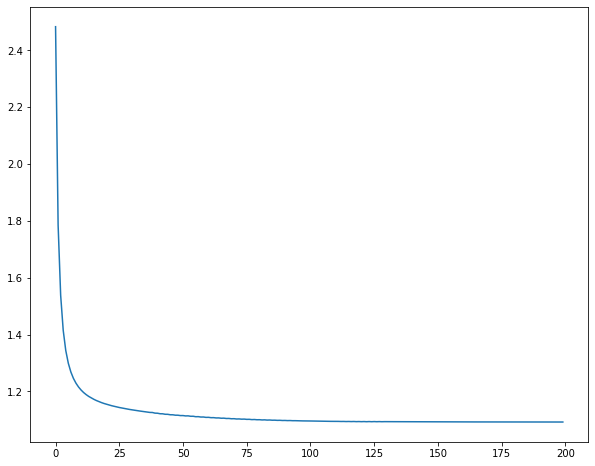

In [10]:
import matplotlib.pyplot as plt
val_losses = [i.tolist() for i in val_losses]
plt.figure(figsize=(10, 8))
plt.plot(val_losses)
print(min(val_losses))